First few rows of the dataset:
  country geoid  iso                    d  cases  deaths  school  \
0   Aruba    AW  ABW  2020-01-01 00:00:00    0.0     0.0     0.0   
1   Aruba    AW  ABW  2020-01-02 00:00:00    0.0     0.0     0.0   
2   Aruba    AW  ABW  2020-01-03 00:00:00    0.0     0.0     0.0   
3   Aruba    AW  ABW  2020-01-04 00:00:00    0.0     0.0     0.0   
4   Aruba    AW  ABW  2020-01-05 00:00:00    0.0     0.0     0.0   

   school_local  domestic  domestic_local  ...  wage  credit  taxc  taxd  \
0           0.0       NaN             NaN  ...   0.0     0.0   0.0   0.0   
1           0.0       NaN             NaN  ...   0.0     0.0   0.0   0.0   
2           0.0       NaN             NaN  ...   0.0     0.0   0.0   0.0   
3           0.0       NaN             NaN  ...   0.0     0.0   0.0   0.0   
4           0.0       NaN             NaN  ...   0.0     0.0   0.0   0.0   

   export  rate  Rigidity_Public_Health  Economic_Measures  population_2019  \
0     0.0   0.0         

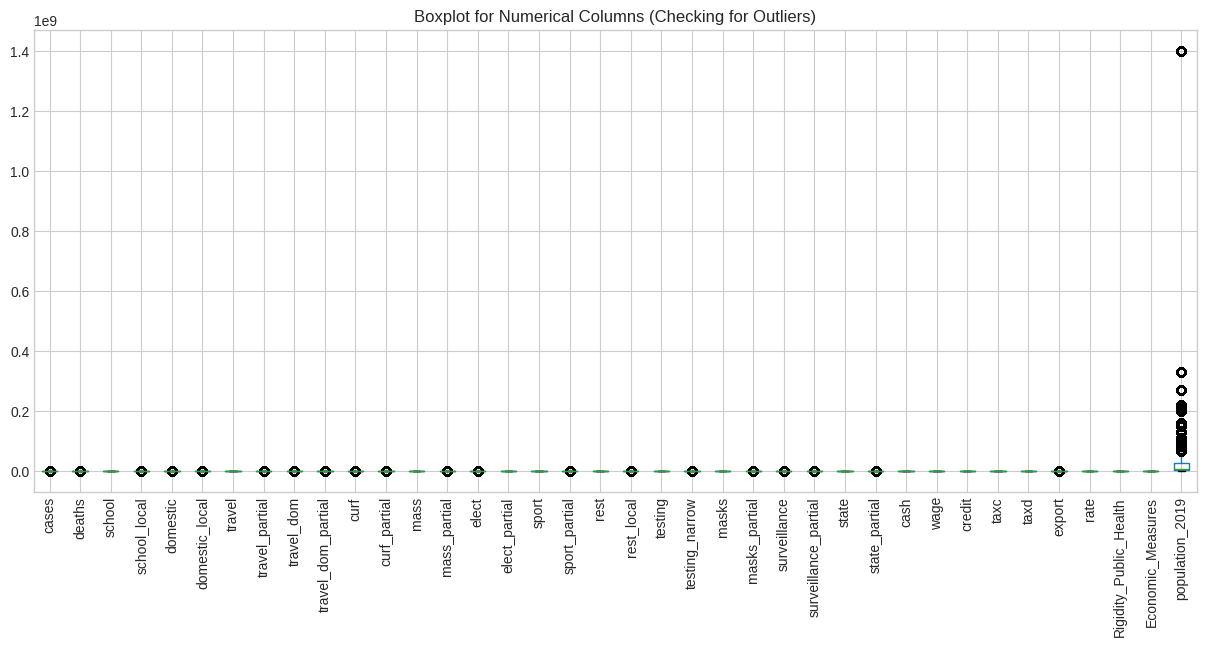

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "Gov_Responses2Covid19_last.xlsx"
df = pd.read_excel(file_path, sheet_name="Dataset")

print("First few rows of the dataset:")
print(df.head())

# 1. Get summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(df.describe())

# Get categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
num_categorical_cols = len(categorical_cols)
print(f"Number of Categorical Columns: {num_categorical_cols}")
print(f"Categorical Columns: {list(categorical_cols)}")

# Get numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns
num_numerical_cols = len(numerical_cols)
print(f"\nNumber of Numerical Columns: {num_numerical_cols}")
print(f"Numerical Columns: {list(numerical_cols)}")

# 2. Count unique values for categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns  # Select categorical columns
print("\nUnique value counts for categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

# 3. Check for outliers using box plots
numerical_cols = df.select_dtypes(include=['number']).columns  # Select numerical columns

# Plot boxplots for numerical columns to visualize outliers
plt.figure(figsize=(15, 6))
df[numerical_cols].boxplot(rot=90)
plt.title("Boxplot for Numerical Columns (Checking for Outliers)")
plt.show()


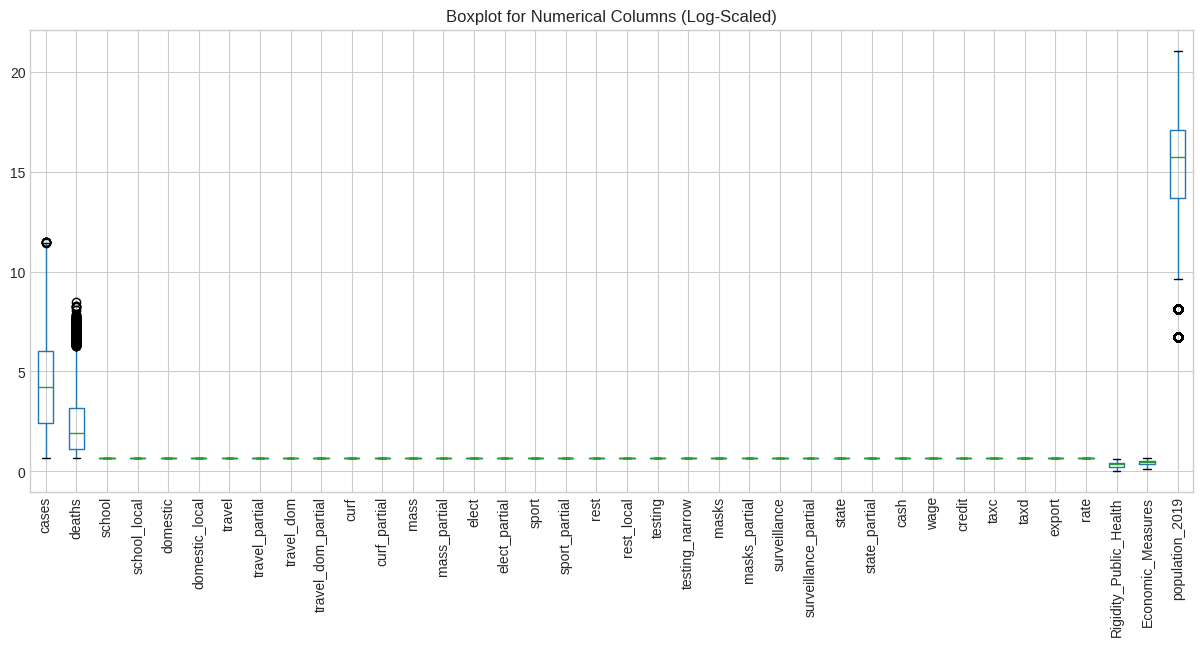

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Avoid log(0) by replacing zeros with NaN (they won't be plotted)
df_log = df[numerical_cols].replace(0, np.nan).apply(np.log1p)  # log1p is log(x+1), avoids log(0)

# Plot boxplot again
plt.figure(figsize=(15, 6))
df_log.boxplot(rot=90)
plt.title("Boxplot for Numerical Columns (Log-Scaled)")
plt.show()


In [12]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

geoid                       275
cases                      4950
deaths                     4950
school                    16942
school_local              16942
domestic                   7425
domestic_local             7425
travel                     7425
travel_partial             7425
travel_dom                 7425
travel_dom_partial         7425
curf                       7425
curf_partial               7425
mass                       7425
mass_partial               7425
elect                     47866
elect_partial             47866
sport                      7425
sport_partial              7425
rest                       7425
rest_local                 7425
testing                    7425
testing_narrow             7425
masks                     11241
masks_partial             11241
surveillance               7425
surveillance_partial       7425
state                      7425
state_partial              7425
cash                       8250
wage                       8250
credit  

In [13]:
import pandas as pd

# Forward-fill and backward-fill for categorical policy measures within each country
policy_cols = ['school', 'school_local', 'masks', 'masks_partial', 'domestic', 'domestic_local',
               'travel', 'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf', 'curf_partial',
               'mass', 'mass_partial', 'elect', 'elect_partial', 'sport', 'sport_partial', 'rest',
               'rest_local', 'testing', 'testing_narrow', 'surveillance', 'surveillance_partial',
               'state', 'state_partial']

df[policy_cols] = df.groupby(['geoid', 'country'], group_keys=False)[policy_cols].apply(lambda group: group.ffill().bfill())

# Fill remaining missing policy values with 0 (assuming no policy intervention)
df[policy_cols] = df[policy_cols].fillna(0)

# Linear interpolation for economic measures within each country
economic_cols = ['wage', 'taxc', 'credit', 'cash', 'export', 'rate', 'Economic_Measures']
df[economic_cols] = df.groupby(['geoid', 'country'], group_keys=False)[economic_cols].apply(lambda group: group.interpolate(method='linear'))

# Fill remaining missing economic values with 0 (assuming no intervention)
df[economic_cols] = df[economic_cols].fillna(0)

# Rolling average for cases and deaths (7-day window)
df[['cases', 'deaths']] = df.groupby(['geoid', 'country'], group_keys=False)[['cases', 'deaths']].apply(
    lambda group: group.fillna(group.rolling(7, min_periods=1).mean())
)

# Fill remaining missing cases & deaths with 0
df[['cases', 'deaths']] = df[['cases', 'deaths']].fillna(0)

# Drop election-related variables (optional)
df.drop(columns=['elect', 'elect_partial'], errors='ignore', inplace=True)

# Mean imputation for population within the same continent
df['population_2019'] = df.groupby('continent')['population_2019'].transform(lambda x: x.fillna(x.mean()))

# Fill missing continent values using most frequent value (mode)
df['continent'].fillna(df['continent'].mode()[0], inplace=True)

# Fill missing geoid with country ISO code (if applicable)
df['geoid'].fillna(df['iso'], inplace=True)

df['taxd'].fillna(0, inplace=True)
df['Rigidity_Public_Health'].fillna(0, inplace=True)

# Fill remaining missing population with global mean
df['population_2019'].fillna(df['population_2019'].mean(), inplace=True)

# Ensure index alignment
df.reset_index(drop=True, inplace=True)

# Check missing values again
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Series([], dtype: int64)


<ipython-input-13-3585b52f12ae>:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['continent'].fillna(df['continent'].mode()[0], inplace=True)
<ipython-input-13-3585b52f12ae>:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [14]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
print(len(df))
print(len(df.columns))
print(df['country'].nunique())

Series([], dtype: int64)
62700
41
228


Missing values in key columns:
cases     0
deaths    0
dtype: int64


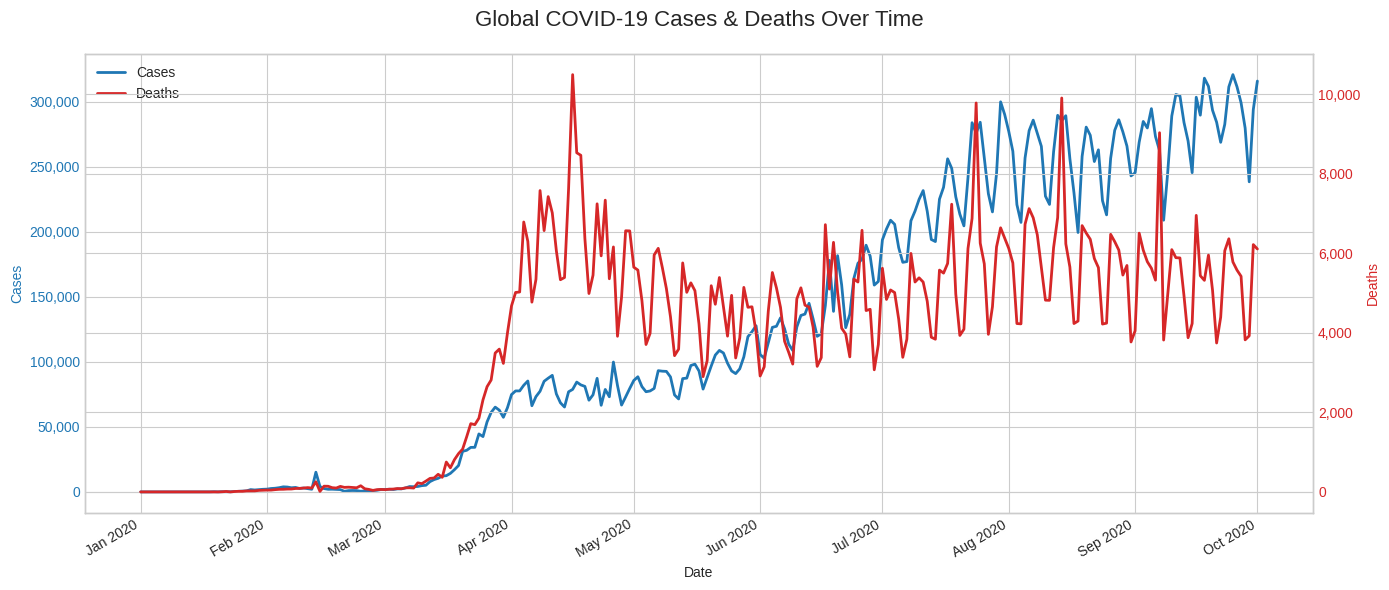

Top 5 countries by total cases: ['United States of America', 'India', 'Brazil', 'Russia', 'Colombia']


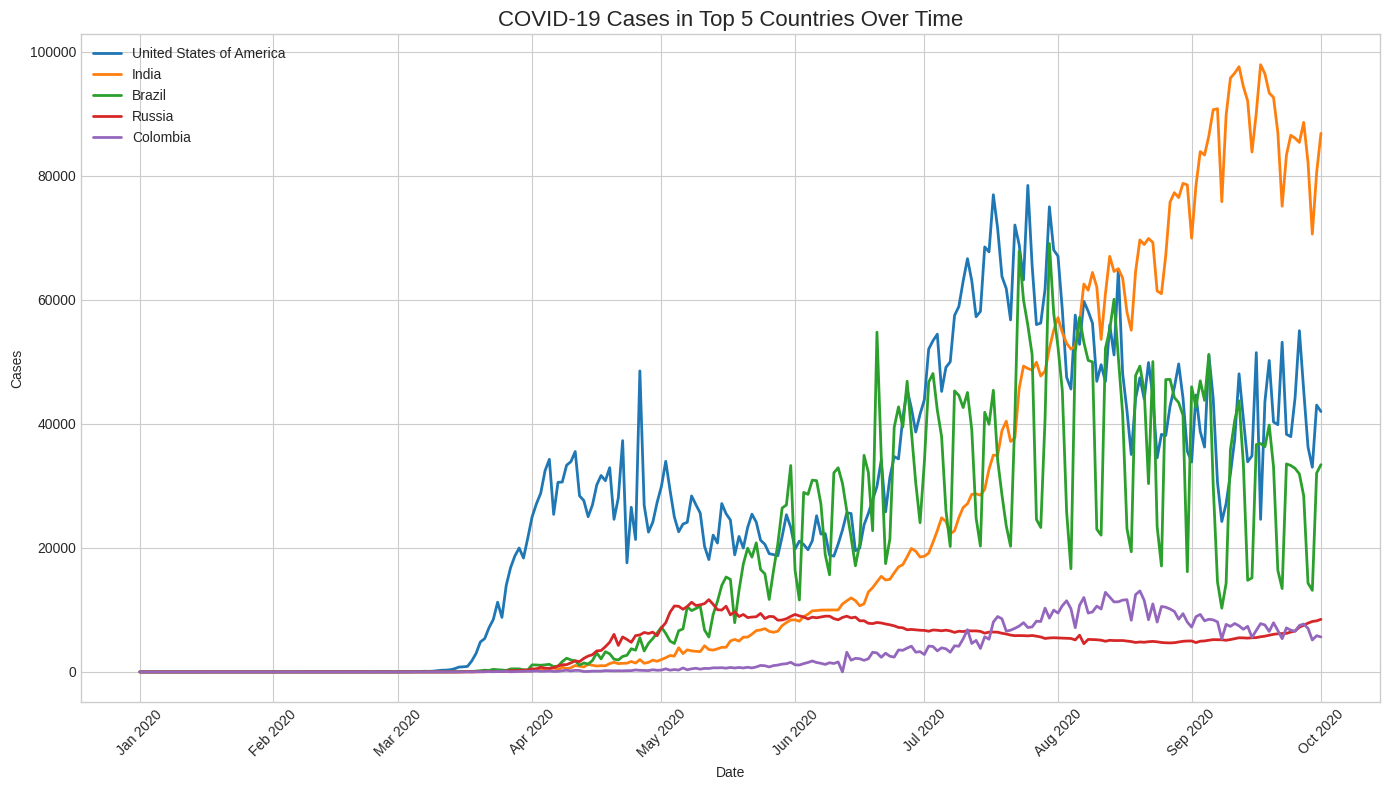

Available policy-related columns: ['school', 'school_local', 'domestic', 'domestic_local', 'travel', 'travel_partial', 'travel_dom', 'travel_dom_partial', 'masks', 'masks_partial', 'Rigidity_Public_Health']


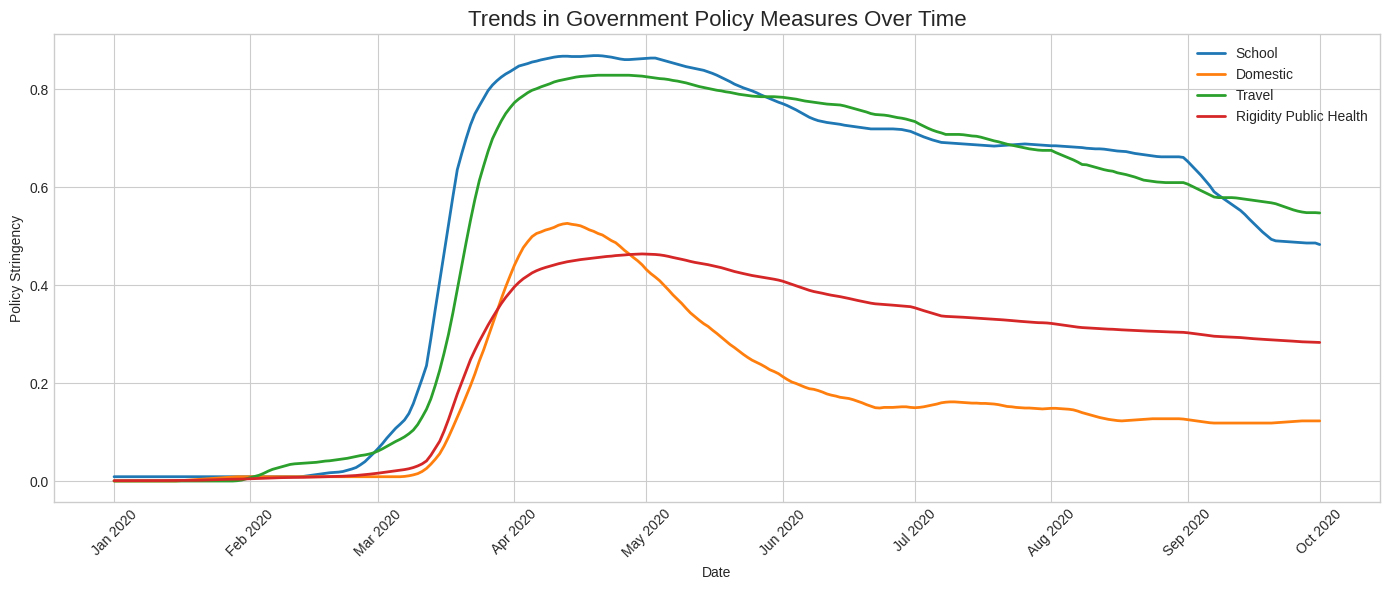

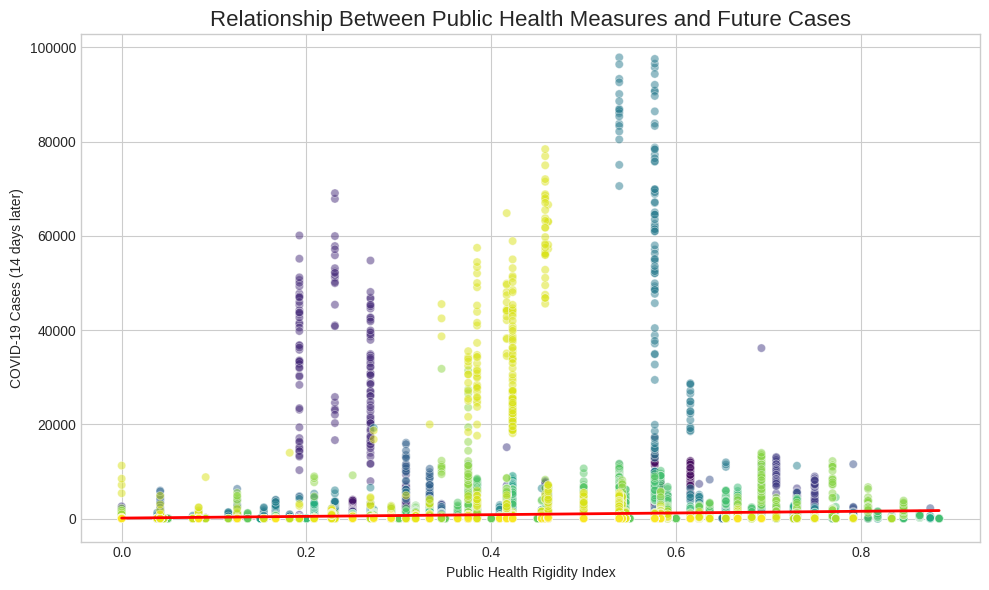

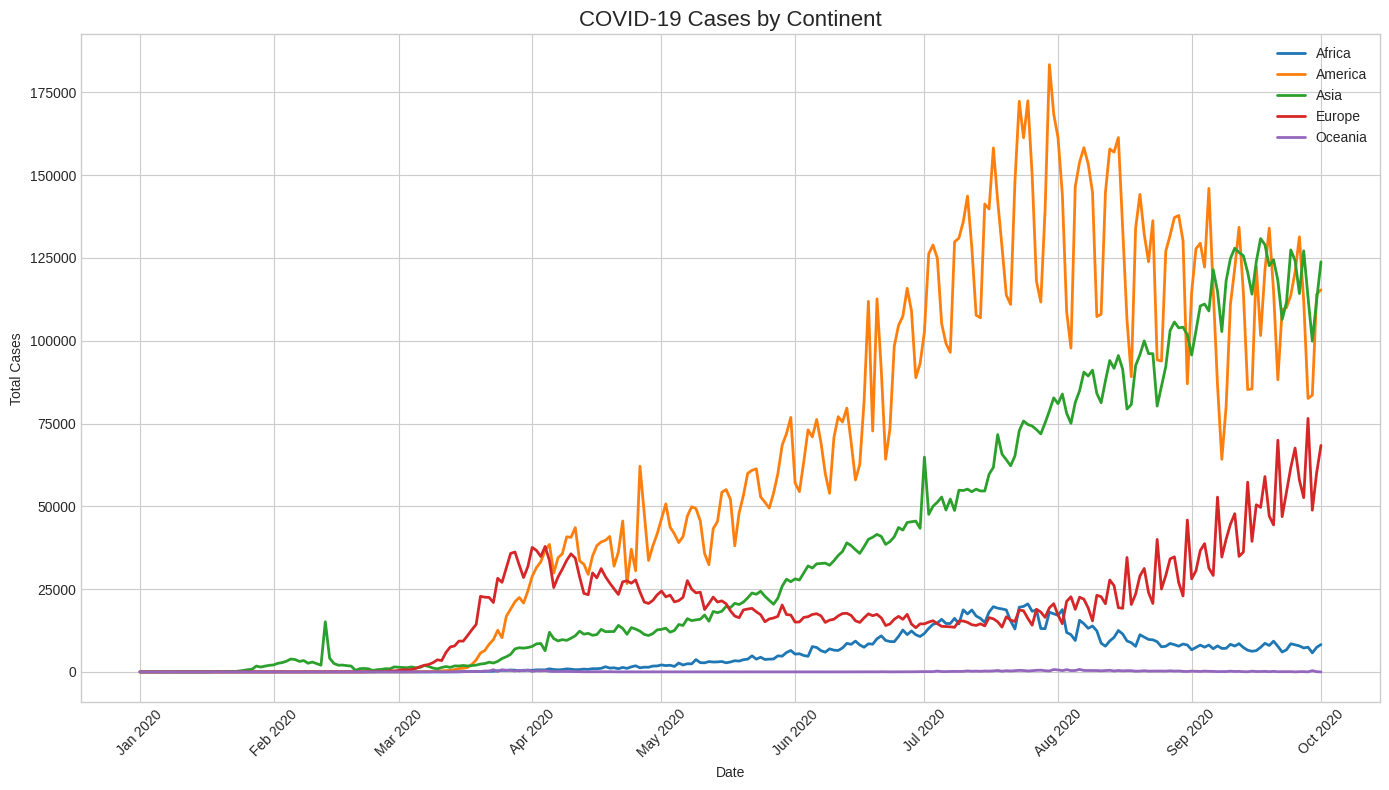

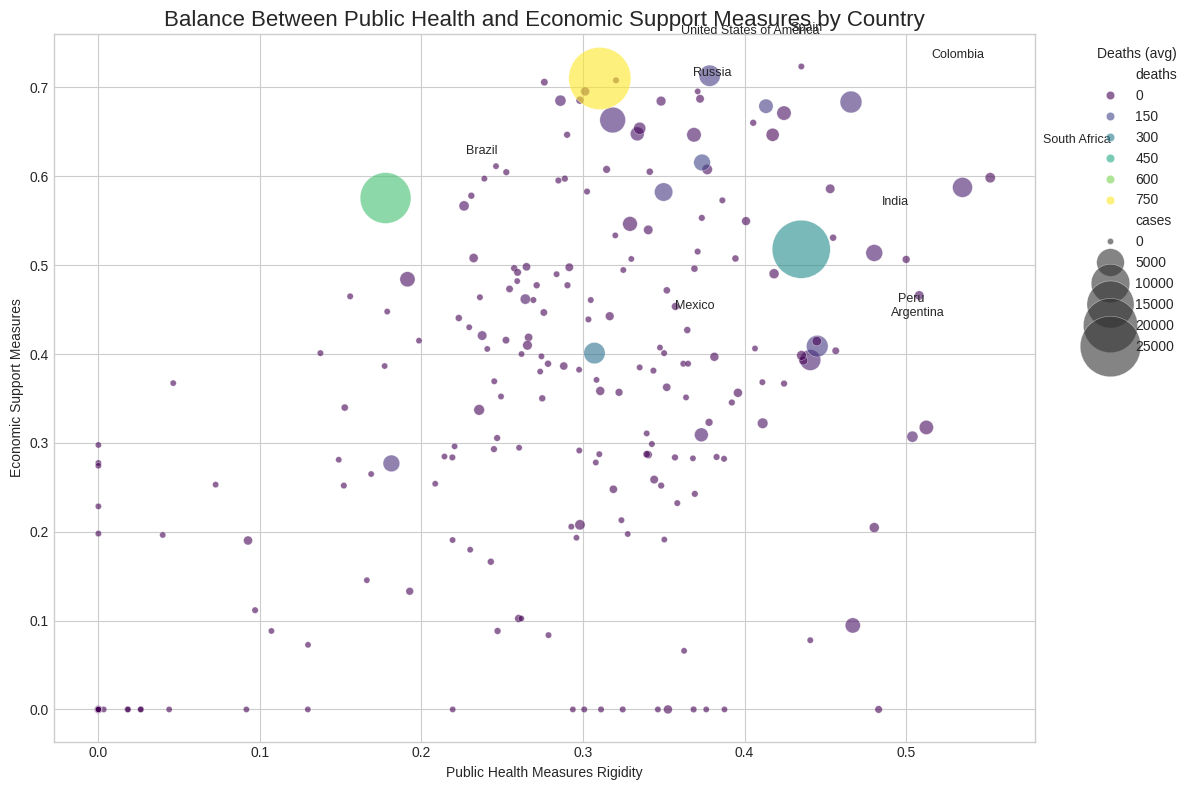

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['d'])

# Check for missing values and handle them
print(f"Missing values in key columns:\n{df[['cases', 'deaths']].isna().sum()}")
df['cases'] = df['cases'].fillna(0)
df['deaths'] = df['deaths'].fillna(0)

# Create proper policy columns based on actual dataset columns
policy_columns = ['school', 'domestic', 'travel', 'Rigidity_Public_Health']
valid_policy_columns = [col for col in policy_columns if col in df.columns]

# Apply better styling for plots
plt.style.use('seaborn-v0_8-whitegrid')

### 1️⃣ COVID-19 Cases & Deaths Over Time (Global & Country-wise) ###

# Global trends with improved visualization
global_trends = df.groupby('date')[['cases', 'deaths']].sum().sort_index()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot cases
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Cases', color=color)
ax1.plot(global_trends.index, global_trends['cases'], label='Cases', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Create second y-axis for deaths
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Deaths', color=color)
ax2.plot(global_trends.index, global_trends['deaths'], label='Deaths', color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Format date on x-axis
date_form = DateFormatter("%b %Y")
ax1.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

# Add a title and legend
plt.title('Global COVID-19 Cases & Deaths Over Time', fontsize=16, pad=20)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Top 5 countries by total cases
top_countries = df.groupby('country')['cases'].sum().sort_values(ascending=False).head(5).index.tolist()
print(f"Top 5 countries by total cases: {top_countries}")

# Country comparison for top 5 countries
plt.figure(figsize=(14, 8))

for country in top_countries:
    country_data = df[df['country'] == country].groupby('date')['cases'].sum().sort_index()
    plt.plot(country_data.index, country_data, label=country, linewidth=2)

plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID-19 Cases in Top 5 Countries Over Time', fontsize=16)
plt.legend()
plt.gca().xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2️⃣ Enhanced Policy Analysis ###

# Check if we have the right policy columns first
print(f"Available policy-related columns: {[col for col in df.columns if any(policy in col.lower() for policy in ['school', 'domestic', 'travel', 'restrict', 'policy', 'lockdown', 'mask', 'rigidity'])]}")

# Only use columns that exist in the dataset
valid_policy_columns = [col for col in policy_columns if col in df.columns]

if valid_policy_columns:
    # Create a rolling average for smoother visualization
    policy_trends = df.groupby('date')[valid_policy_columns].mean().sort_index()
    policy_trends_smooth = policy_trends.rolling(window=7, min_periods=1).mean()

    plt.figure(figsize=(14, 6))
    for col in valid_policy_columns:
        plt.plot(policy_trends_smooth.index, policy_trends_smooth[col], label=col.replace('_', ' ').title(), linewidth=2)

    plt.xlabel('Date')
    plt.ylabel('Policy Stringency')
    plt.title('Trends in Government Policy Measures Over Time', fontsize=16)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No valid policy columns found in the dataset. Please check column names.")

### 3️⃣ Improved Policy vs. Cases Analysis ###

# Use proper policy columns and aggregate data appropriately
if 'Rigidity_Public_Health' in df.columns:
    # Prepare data for analysis - aggregate by country and date
    policy_cases_data = df.groupby(['country', 'date'])[['Rigidity_Public_Health', 'cases']].mean().reset_index()

    # Create lag for cases to account for policy impact delay (14 days)
    policy_cases_data['country_date'] = policy_cases_data['country'] + policy_cases_data['date'].astype(str)
    policy_cases_data['future_cases'] = policy_cases_data.groupby('country')['cases'].shift(-14)

    # Remove rows with NaN values
    policy_cases_data = policy_cases_data.dropna()

    # Create visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=policy_cases_data,
        x='Rigidity_Public_Health',
        y='future_cases',
        alpha=0.5,
        hue='country',
        palette='viridis',
        legend=False
    )

    # Add regression line
    sns.regplot(
        data=policy_cases_data,
        x='Rigidity_Public_Health',
        y='future_cases',
        scatter=False,
        color='red',
        line_kws={"linewidth": 2}
    )

    plt.xlabel('Public Health Rigidity Index')
    plt.ylabel('COVID-19 Cases (14 days later)')
    plt.title('Relationship Between Public Health Measures and Future Cases', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Rigidity_Public_Health column not found. Skipping policy impact analysis.")

### 4️⃣ Continental Analysis (New) ###

if 'continent' in df.columns:
    # Get cases by continent over time
    continent_cases = df.groupby(['continent', 'date'])['cases'].sum().reset_index()

    # Plot cases by continent
    plt.figure(figsize=(14, 8))

    for continent in continent_cases['continent'].unique():
        continent_data = continent_cases[continent_cases['continent'] == continent]
        plt.plot(continent_data['date'], continent_data['cases'], label=continent, linewidth=2)

    plt.xlabel('Date')
    plt.ylabel('Total Cases')
    plt.title('COVID-19 Cases by Continent', fontsize=16)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Continent column not found. Skipping continental analysis.")

### 5️⃣ Economic Measures vs. Public Health Measures (New) ###

if all(col in df.columns for col in ['Economic_Measures', 'Rigidity_Public_Health']):
    # Aggregate by country
    country_policies = df.groupby('country')[['Economic_Measures', 'Rigidity_Public_Health', 'cases', 'deaths']].mean().reset_index()

    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=country_policies,
        x='Rigidity_Public_Health',
        y='Economic_Measures',
        size='cases',
        sizes=(20, 2000),
        alpha=0.6,
        hue='deaths',
        palette='viridis'
    )

    # Add country labels for top countries
    top_countries_by_cases = country_policies.sort_values('cases', ascending=False).head(10)
    for _, row in top_countries_by_cases.iterrows():
        plt.text(
            x=row['Rigidity_Public_Health'] + 0.05,
            y=row['Economic_Measures'] + 0.05,
            s=row['country'],
            fontsize=9
        )

    plt.xlabel('Public Health Measures Rigidity')
    plt.ylabel('Economic Support Measures')
    plt.title('Balance Between Public Health and Economic Support Measures by Country', fontsize=16)

    # Add legend with better formatting
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles, labels, title="Deaths (avg)", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
else:
    print("Economic_Measures or Rigidity_Public_Health columns not found. Skipping economic vs. health policy analysis.")